<a href="https://colab.research.google.com/github/katterine2558/palette-clustering/blob/main/microproyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOLUCIÓN MICROPROYECTO 1

Por: *Leonardo Almanza y Katerine Arias*

## 1. Importar librerías

En esta etapa inicial se realiza la importación de librerías, un paso fundamental para disponer de todas las herramientas necesarias en el proyecto. Se incluyen librerías de manipulación y análisis de datos (`NumPy`, `Pandas`), visualización (`Matplotlib`, `Seaborn`), procesamiento y reducción de dimensionalidad (`scikit-learn`, `PCA`, `t-SNE`), así como utilidades para el manejo de imágenes (`OpenCV`). Estas librerías permiten aplicar técnicas de machine learning no supervisado, como `K-Means`, con el fin de identificar y agrupar colores predominantes en las imágenes. De esta forma, se facilita la generación automática de paletas de colores representativas, que pueden aplicarse en áreas como diseño gráfico, análisis de estilo visual y visión por computador.

In [62]:
# Importa librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import cv2
from sklearn.base import BaseEstimator, TransformerMixin
from PIL import Image as PILImage



---



## 2. Recopilación de imagenes

En esta etapa se seleccionaron 8 imágenes de artes variados del dataset [WikiArt](https://https://www.kaggle.com/datasets/steubk/wikiart), con el fin de representar un amplio espectro de colores. Estas imágenes se organizaron en un diccionario y se visualizaron en grilla para su verificación previa al análisis.

In [43]:
# Diccionario con nombre de imagenes
imgs_dict = {'image1': 'imgs/a.y.-jackson_smart-river-alaska-1945.jpg',
             'image2': 'imgs/abraham-manievich_camden-1923.jpg',
             'image3':'imgs/adriaen-brouwer_farmers-fight-party.jpg',
             'image4':'imgs/aldemir-martins_baiana-1980.jpg',
             'image5': 'imgs/allen-jones_crazy-horse-1976.jpg',
             'image6': 'imgs/andy-warhol_arnold-schwarzenegger-1977.jpg',
             'image7':'imgs/giorgio-vasari_boccaccio-dante-petrarca.jpg',
             'image8':'imgs/hiroshige_bay-at-kominato-in-awa-province.jpg'}

In [44]:
#Plotea imagenes seleccionadas
def plot_images_grid(image_paths, grid_size=(2, 4), figsize=(10, 8)):
    """
    Plotea las imagenes en grilla.
    Input args:
        image_paths (list): Lista de rutas a las imágenes.
        grid_size (tuple): Tamaño de la grilla (filas, columnas).
        figsize (tuple): Tamaño de la figura.
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths):
        if i < len(axes):
            try:
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"Image {i+1}")
                axes[i].axis('off')
            except FileNotFoundError:
                axes[i].set_title(f"Image {i+1} not found")
                axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

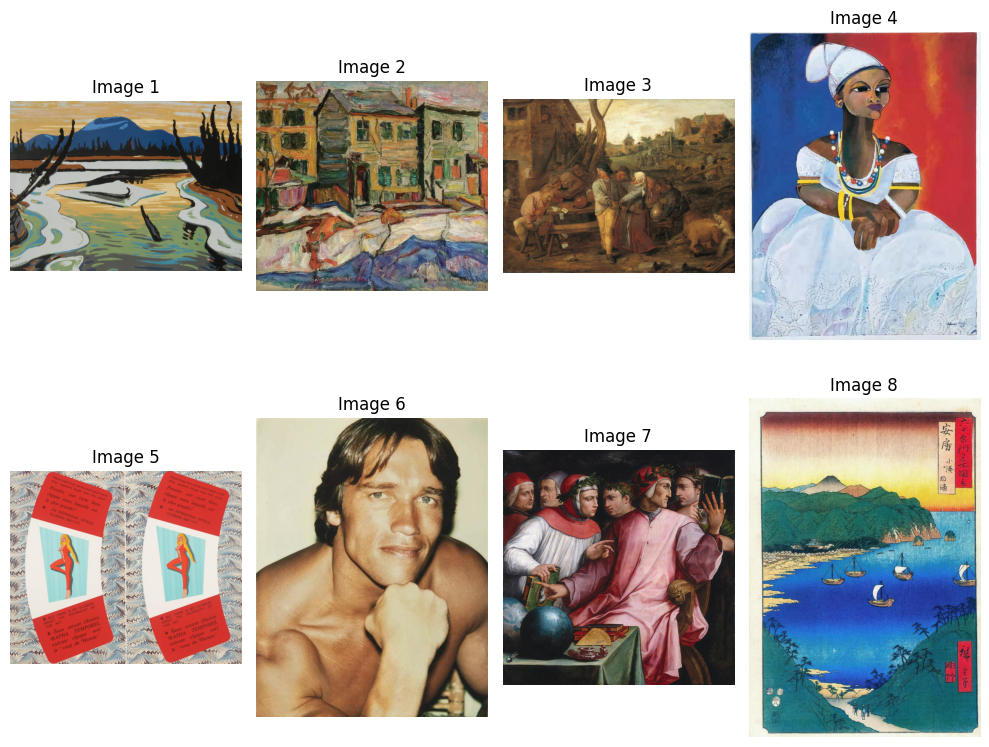

In [45]:
# Plot de imagenes
image_paths_list = list(imgs_dict.values())
plot_images_grid(image_paths_list)



---



## 3. Preparación de los datos

La preparación de los datos es crucial antes de aplicar un algoritmo, especialmente con imágenes y en entornos no supervisados: estandariza las entradas, reduce ruido y estabiliza el espacio donde se comparan colores, evitando sesgos y mejorando la convergencia y la interpretabilidad de los resultados. Es por esto que se implementarán clases de preparación, las cuales se integrarán al `pipeline` para garantizar datos consistentes, comparables y listos para el algoritmo de agrupamiento.

### 3.1. Clase Image

La clase `Image` funciona como un contenedor ligero de estado: inicia con `image=None` y almacena la matriz de la imagen a medida que avanza el proceso. Así, los transformadores del pipeline pueden compartir y actualizar la misma referencia (p. ej., la versión RGB ya cargada) sin releer el archivo ni duplicar datos innecesariamente.

In [46]:
#Obtiene la imagen
class Image:
  def __init__(self):
      self.image = None

### 3.2. Clase ImageReader

`ImageReader` es un transformador compatible con `scikit-learn` que se encarga de cargar la imagen desde una ruta usando `cv2.imread`. Mantiene el contrato de un pipeline (fit sin aprendizaje y transform que realiza la acción) y devuelve la matriz de la imagen (ndarray en BGR) lista para las siguientes etapas. El parámetro image permite integrarse con el estado compartido del flujo, aunque en este paso solo realiza la lectura.

In [47]:
#Carga la imagen
class ImageReader(BaseEstimator, TransformerMixin):
  def __init__(self, image):
    self.image = image

  def fit(self, X, y=None):
    return self

  def transform(self, path):
    img = cv2.imread(path)
    return img

### 3.3. Clase ImageResizer

`ImageResizer` es un transformador compatible con scikit-learn que ajusta el tamaño de la imagen manteniendo la proporción para que su área no supere max_side². Calcula un factor de escala y, si es necesario, reduce la imagen con `cv2.resize(..., INTER_AREA)`, óptimo para downsampling. Esto disminuye el costo computacional y la memoria sin perder la estructura cromática relevante para el clustering. Si la imagen ya es pequeña, la devuelve sin cambios.

In [48]:
#Redimensiona la imagen
class ImageResizer(BaseEstimator, TransformerMixin):
  def __init__(self, image, max_side=100):
    self.image = image
    self.max_side = max_side

  def fit(self, X, y=None):
    return self

  def transform(self, X):
      scale = self._calc_scale(X)
      if scale != 1:
          new_w = int(X.shape[1] * scale)
          new_h = int(X.shape[0] * scale)
          return cv2.resize(X, (new_w, new_h), interpolation=cv2.INTER_AREA)
      return X

  def _calc_scale(self, img):

      max_area = self.max_side ** 2
      h, w = img.shape[:2]
      img_area = h * w
      if img_area > max_area:
          factor = np.sqrt(max_area / float(img_area))
      else:
          factor = 1.0
      return factor


### 3.4. Clase Convert2RGB

`Convert2RGB` es un transformador que estandariza el espacio de color pasando de BGR (`OpenCV`) a RGB. Guarda la imagen convertida en el estado compartido (self.image.image) y devuelve una matriz de forma (N, 3) donde cada fila es un píxel [R, G, B], lista para alimentar algoritmos de agrupamiento (p. ej., K-Means) u operaciones posteriores como la normalización. No aprende parámetros durante fit; solo convierte y reestructura los datos.

In [49]:
#Convierte a RGB
class Convert2RGB(BaseEstimator, TransformerMixin):

  def __init__(self, image):
      self.image = image

  def fit(self, X, y=None):
    return self

  def transform(self, X):

    rgb_img = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    self.image.image = rgb_img
    return rgb_img.reshape((-1, 3))

### 3.5. ImageNormalizer

`ImageNormalizer` es un transformador que escala linealmente los valores de cada píxel de [0, 255] a [0, 1] (dividiendo por 255). Esta normalización estabiliza las distancias usadas por los algoritmos de clustering, evita que la intensidad bruta domine el resultado y mejora la convergencia.

In [50]:
#Normaliza la imagen
class ImageNormalizer(BaseEstimator, TransformerMixin):

  def __init__(self, image):
      self.image = image

  def fit(self, X, y=None):
    return self

  def transform(self,X):
    return X / 255



---



## 4. Construcción de pipeline

Aquí se construye el pipeline: un flujo secuencial de transformaciones compatible con scikit-learn que encapsula la preparación de datos de forma modular, reusable y reproducible. Definirlo como un único objeto asegura aplicar exactamente el mismo proceso a todas las imágenes, reduce errores de consistencia y centraliza la configuración.

Este pipeline encadena cuatro pasos: primero, `image_reader` lee la imagen desde su ruta y la convierte en matriz; luego, `image_resizer` ajusta su tamaño manteniendo la proporción para hacer el procesamiento eficiente y comparable. Después, `resizedimage_to_rgb` transforma de BGR a RGB y reestructura los datos como una tabla de píxeles
(N,3)
(N,3). Por último, `rgb_normalizer` escala los valores de [0,255] a [0,1], estabilizando las distancias para el clustering. Con esto, una ruta de archivo se vuelve una representación numérica limpia y estandarizada, lista para extraer la paleta de colores.

In [51]:
#Crea el pipeline
def create_pipeline(image):
  """
  Crea el pipeline para la transformación de datos.
  Input args:
    -image: Image Contenedor ligero de estado compartido; permite que los transformadores accedan/actualicen la imagen procesada (p. ej., versión RGB).
  """
  steps = [
      ('image_reader', ImageReader(image)),
      ('image_resizer', ImageResizer(image)),
      ('resizedimage_to_rgb', Convert2RGB(image)),
      ('rgb_normalizer', ImageNormalizer(image))
  ]
  pipeline = Pipeline(steps)
  return pipeline



---



## 5. Construcción del modelo

**¿Por qué K-means?**

Para extraer paletas, los píxeles en el espacio RGB suelen formar grupos compactos y aproximadamente convexos (colores afines). K-Means es rápido, sencillo y escalable para este tipo de datos; además, permite fijar k (p. ej., 5–7 colores) para obtener directamente el tamaño de la paleta. Su criterio de optimización (minimizar la inercia intra-cluster) encaja bien con la idea de “color representativo”.


**Parámetros de K-means**

* `n_clusters`: número de colores a encontrar (se prueba cada valor del grid).

* `init='k-means++'`: inicialización más estable y rápida que reduce malas semillas.

* `max_iter=500`: tope de iteraciones para asegurar convergencia.

* `random_state=0`: hace el resultado reproducible entre corridas.

**¿Por qué Silhouette e inercia?**

Silhouette evalúa a la vez cohesión y separación de los clusters, ofreciendo una señal interpretable de si los grupos de color están bien delimitados (y además desincentiva un k excesivo). Por otra parte, la inercia es la función objetivo de K-Means (SSE intra-cluster): garantiza compactación y sirve de respaldo cuando la Silhouette no alcanza el umbral (p. ej., imágenes casi monocolor). En conjunto, Silhouette prioriza paletas claras y separadas, la inercia asegura consistencia con el criterio de optimización del algoritmo.

In [55]:
def find_optimal_clusters_kmeans(data, param_grid, min_silhouette_score):
    """
    Encuentra el modelo óptimo de K-Means basado en Silhouette Score e Inertia
    Input args:
      - data: matriz transformada de las imagenes
      - param_grid: diccionario con el hiperparámetro a optimizar
      - min_silhouette_score: valor mínimo aceptado para el Silhouette Score
    Output args:
      - diccionario con métricas
    """

    scores_silhouette, scores_inertia, model_labels, models = [], [], [], []

    for n_clusters in param_grid['n_clusters']:
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, random_state=0)
        kmeans.fit(data)
        labels = kmeans.labels_
        model_labels.append(labels)
        num_clusters = len(set(labels))

        if num_clusters > 1:
            score_silhouette = silhouette_score(data, labels)
            score_inertia = kmeans.inertia_
            scores_silhouette.append(score_silhouette)
            scores_inertia.append(score_inertia)
            models.append(kmeans)
        else:
            scores_silhouette.append(-1)
            scores_inertia.append(0)
            models.append(kmeans)

    # Selección del mejor modelo
    best_score = max(scores_silhouette)
    if best_score > min_silhouette_score:
        print(f'Best silhouette score: {best_score:.4f}')
        best_model_index = scores_silhouette.index(best_score)
        print(f"Selected based on Silhouette Score (k={param_grid['n_clusters'][best_model_index]})")
        score_type = 'silhouette'
    else:
        # Si ningún Silhouette es suficientemente bueno, usar Inertia
        valid_inertias = [inertia for inertia in scores_inertia if inertia > 0]
        if valid_inertias:
            best_score = min(valid_inertias)
            best_model_index = scores_inertia.index(best_score)
            print(f'Best inertia score: {best_score:.2f}')
            print(f"Selected based on Inertia (k={param_grid['n_clusters'][best_model_index]})")
            score_type = 'inertia'

    best_model = models[best_model_index]

    return {
        'best_model': best_model,
        'best_score': best_score,
        'score_type': score_type,
        'model_labels': model_labels[best_model_index],
        'silhouette_scores': scores_silhouette,
        'inertia_scores': scores_inertia
    }

La siguiente función crea una figura de dos paneles para evaluar el modelo `K-Means` seleccionado. A la izquierda traza los coeficientes de silueta por cluster, dibujando la línea roja del promedio global y una línea punteada en el umbral `min_silhouette_score` que se define como mínimo aceptable. A la derecha muestra la dispersión 2D de los datos coloreada por etiquetas (si hay >2 features, proyecta con PCA solo para visualizar) y marca los centroides numerados. Recibe la iamgen descompuesta en matriz y el `results_dict` devuelto por la búsqueda del mejor K-Means.

In [56]:
def plot_kmeans_silhouette_and_clusters(data, results_dict, min_silhoutte_score,use_pca_if_needed=True, figsize=(18,6), random_state=0):
    """
    Genera una figura con:
      - Izquierda: gráfico de coeficientes de silhouette por cluster + línea del promedio.
      - Derecha: dispersión de los datos (2D) coloreada por etiqueta y centros anotados.

    Input args:
        data: np.ndarray o matriz (n_muestras, n_features) usada para entrenar K-Means.
        results_dict: dict con llaves:
            'best_model', 'model_labels' (del mejor), 'silhouette_scores', 'inertia_scores', ...
        min_silhoutte_score: valor mínimo aceptado para el Silhouette Score
        use_pca_if_needed: si hay >2 features, reduce a 2D con PCA solo para graficar.
        figsize: tamaño de la figura.
        random_state: semilla para PCA (solo visualización).
    Returns:
        (fig, (ax1, ax2))
    """
    kmeans = results_dict['best_model']
    labels = np.asarray(results_dict['model_labels'])
    n_clusters = len(np.unique(labels))
    if n_clusters < 2:
        raise ValueError("El gráfico de silhouette requiere al menos 2 clusters.")

    # -------- Panel 1: Silhouette --------
    sample_sil = silhouette_samples(data, labels)
    sil_avg = silhouette_score(data, labels)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_vals = sample_sil[labels == i]
        ith_vals.sort()
        size_i = ith_vals.shape[0]
        y_upper = y_lower + size_i
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10

    # línea del promedio (ya estaba)
    avg_line = ax1.axvline(x=sil_avg, color="red", linestyle="--", linewidth=1, label="Silhouette promedio")

    # NUEVO: línea del umbral mínimo aceptado
    thr_line = None
    if min_silhoutte_score is not None:
        thr_line = ax1.axvline(x=min_silhoutte_score, color="black", linestyle=":", linewidth=1.5,
                               label=f"Umbral mínimo ({min_silhoutte_score:.2f})")

    # leyenda (solo si hay el umbral para no saturar)
    if thr_line is not None:
        ax1.legend(loc="lower right")

    # -------- Panel 2: Dispersión 2D --------
    # Prepara X2D únicamente para visualizar
    if data.shape[1] == 1:
        X2D = np.c_[data, np.zeros((data.shape[0], 1))]
        centers2D = np.c_[kmeans.cluster_centers_, np.zeros((n_clusters, 1))]
    elif data.shape[1] >= 2 and not use_pca_if_needed:
        X2D = data[:, :2]
        centers2D = kmeans.cluster_centers_[:, :2]
    else:
        pca = PCA(n_components=2, random_state=random_state)
        X2D = pca.fit_transform(data)
        centers2D = pca.transform(kmeans.cluster_centers_)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    colors = plt.cm.nipy_spectral(labels.astype(float) / n_clusters)
    ax2.scatter(X2D[:, 0], X2D[:, 1], marker='.', s=30, lw=0, c=colors, alpha=0.7)

    # Centros en blanco con borde negro y etiqueta
    ax2.scatter(centers2D[:, 0], centers2D[:, 1],
                marker='o', c='white', s=400, edgecolors='k', linewidths=1.5, zorder=5)
    for i, (cx, cy) in enumerate(centers2D):
        ax2.text(cx, cy, str(i), va='center', ha='center', fontsize=12,
                 bbox=dict(boxstyle="circle,pad=0.3", fc="white", ec="black", lw=1))

    plt.tight_layout()
    return fig, (ax1, ax2)


image1


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5254
Selected based on Silhouette Score (k=8)


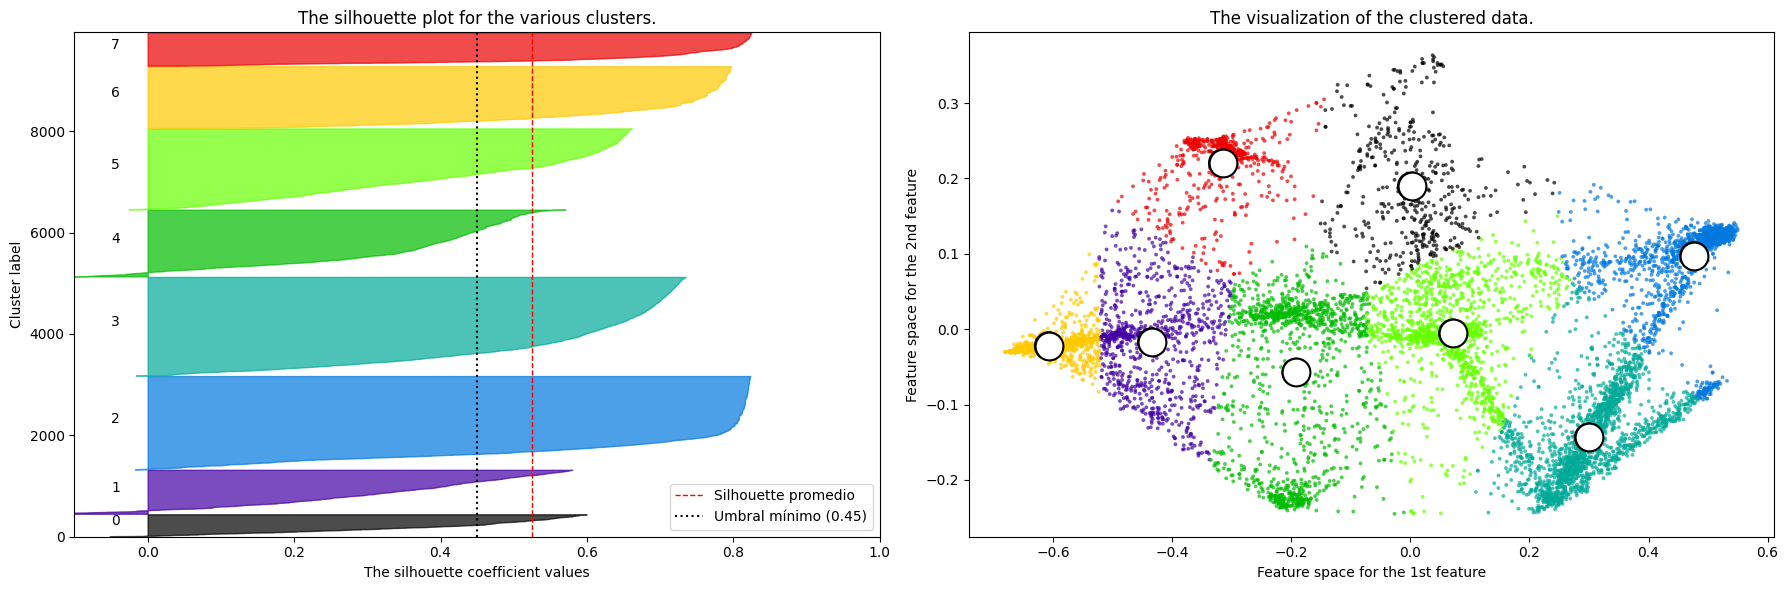

image2


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best inertia score: 60.57
Selected based on Inertia (k=12)


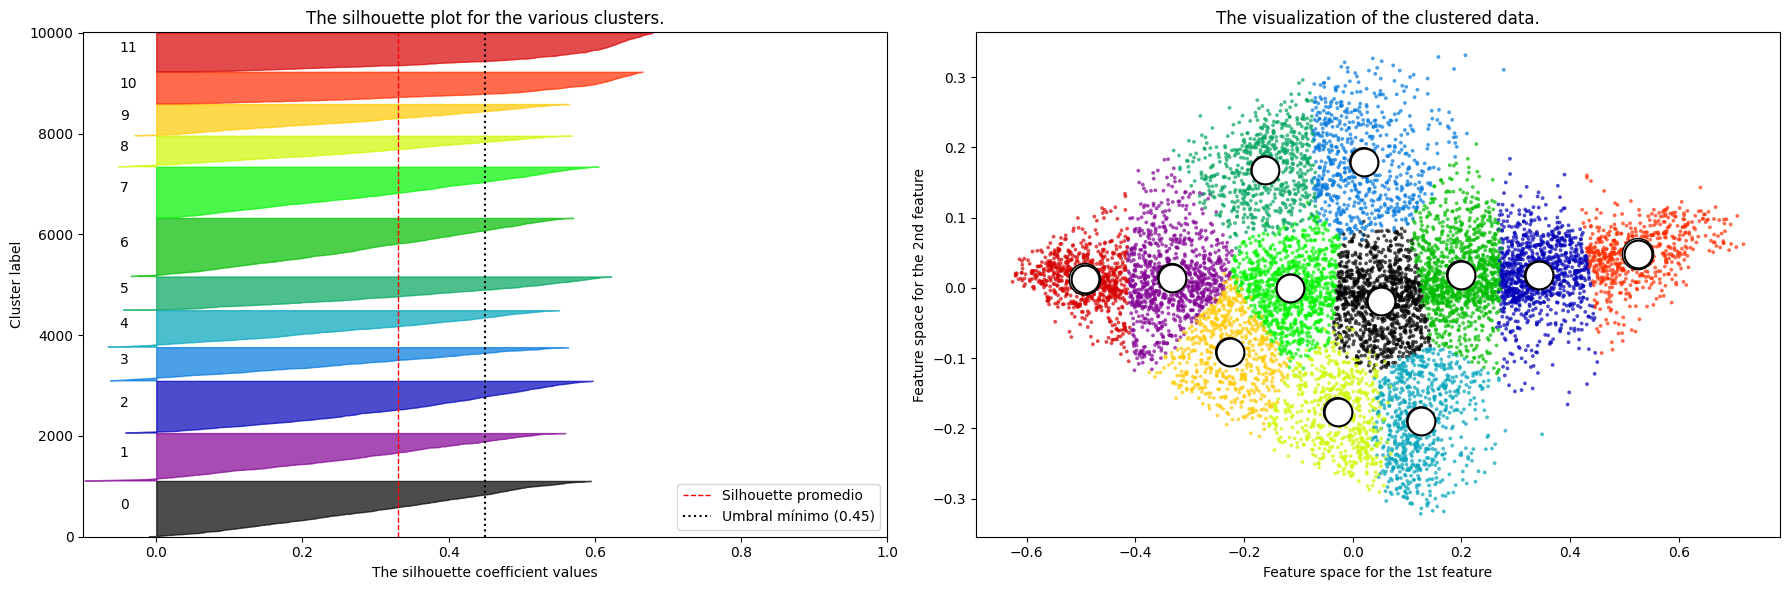

image3


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.4948
Selected based on Silhouette Score (k=5)


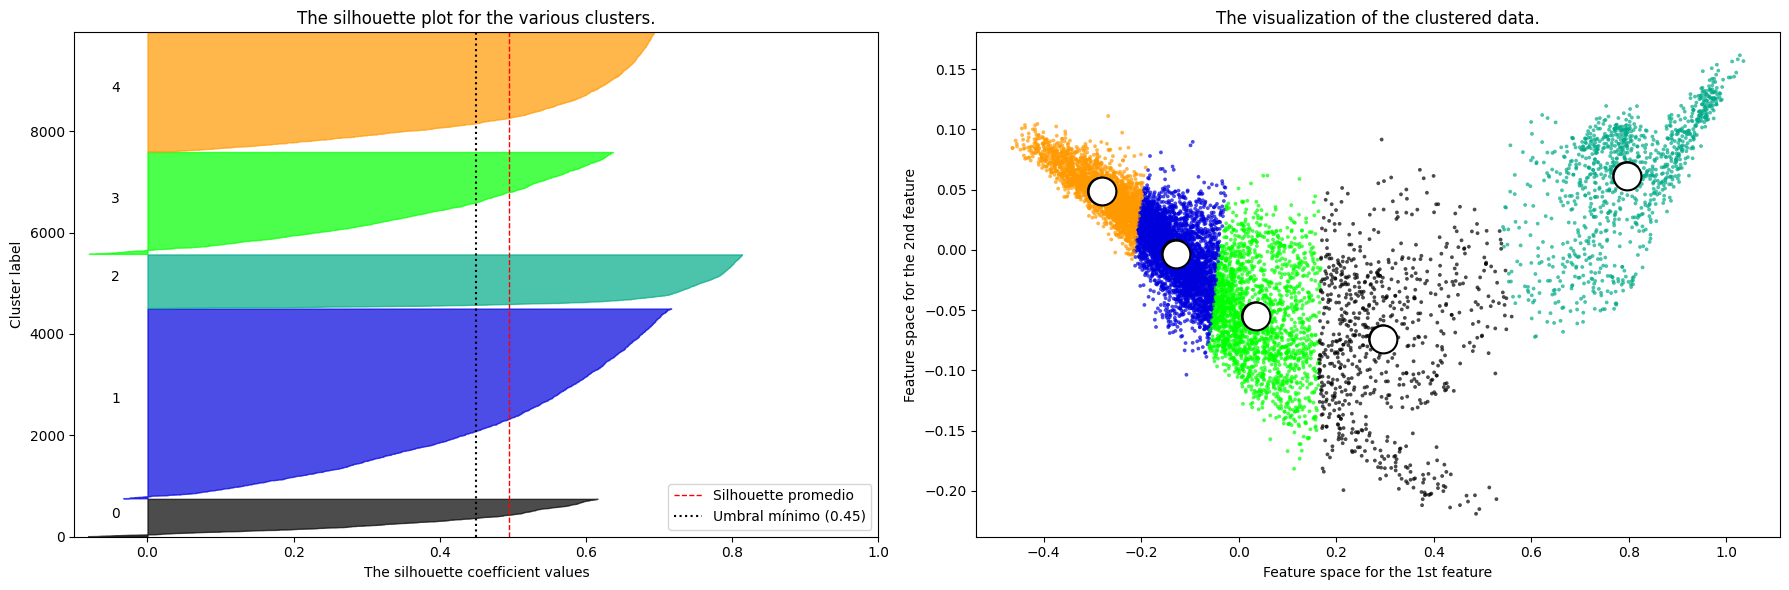

image4


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.7070
Selected based on Silhouette Score (k=5)


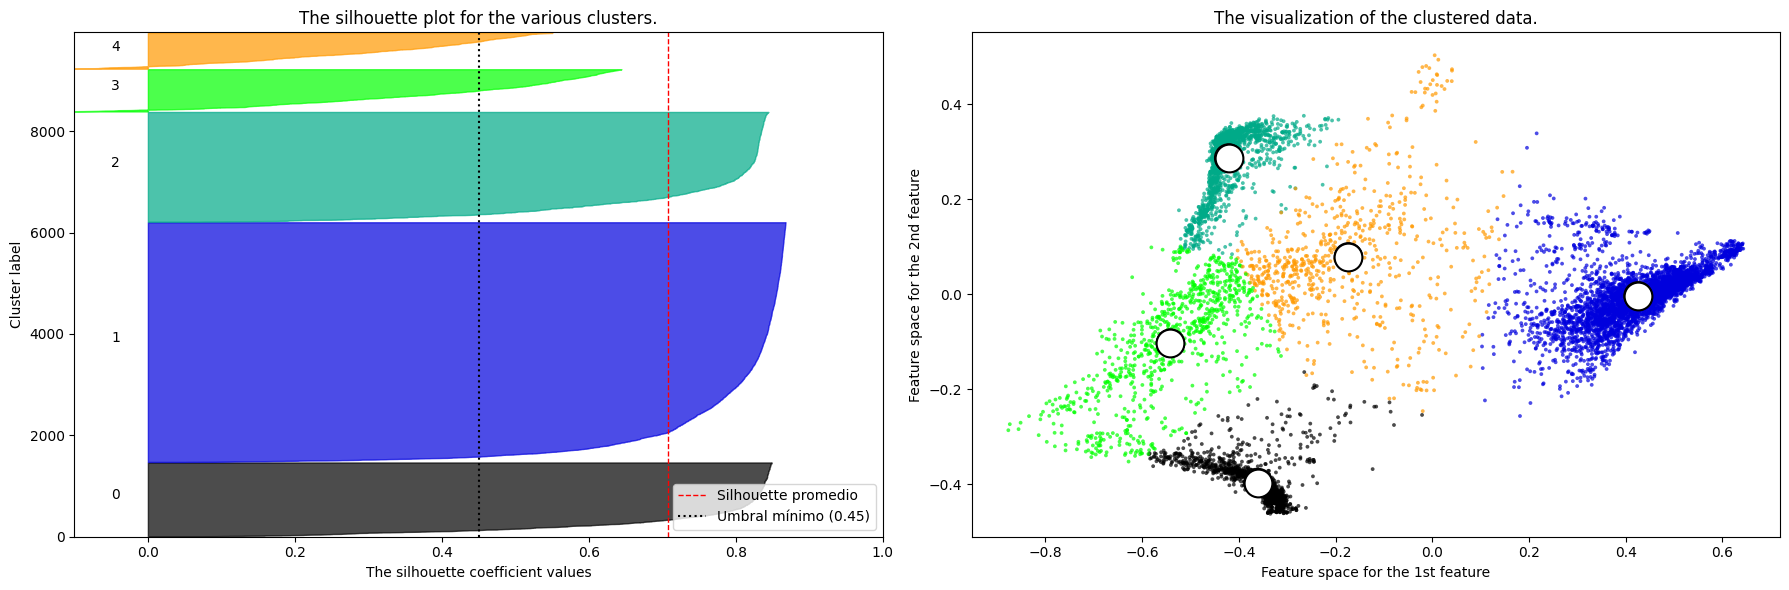

image5


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5539
Selected based on Silhouette Score (k=8)


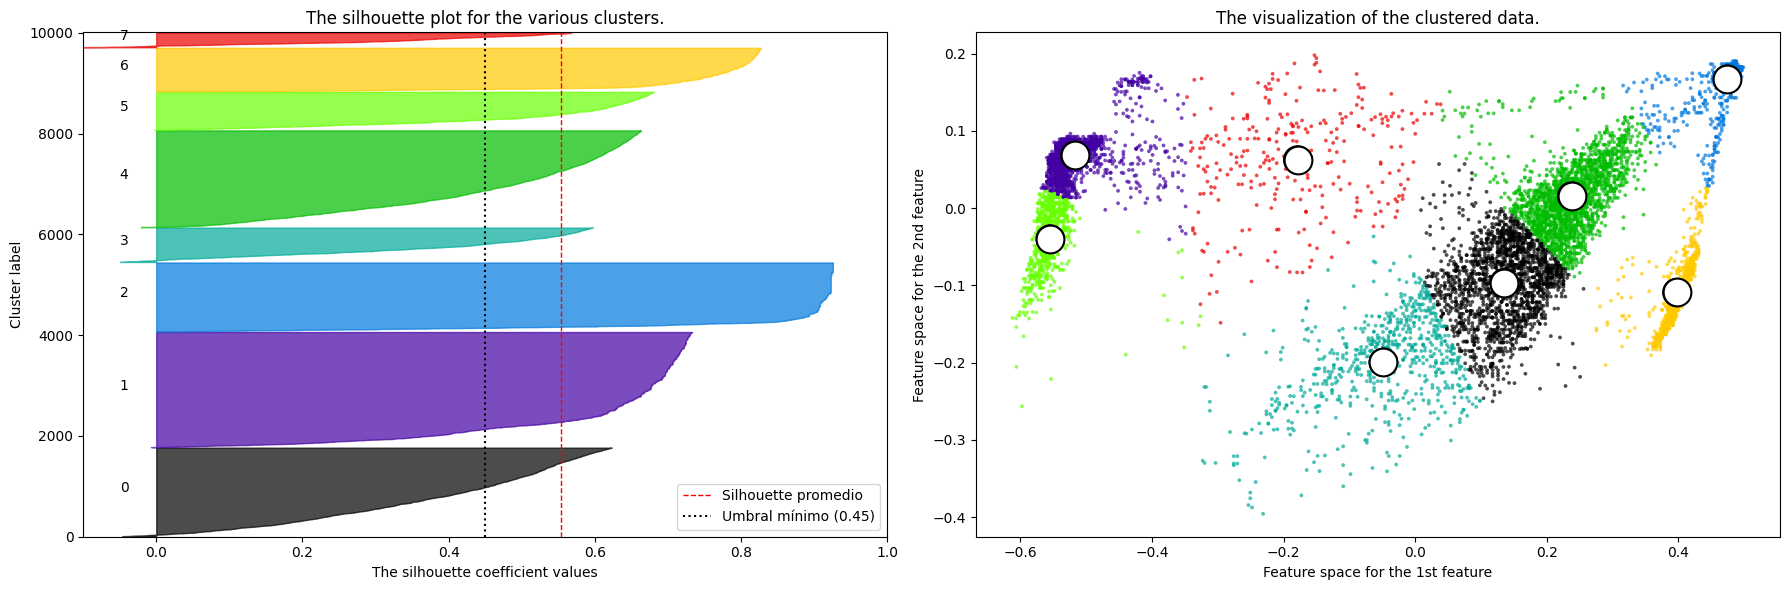

image6


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5451
Selected based on Silhouette Score (k=5)


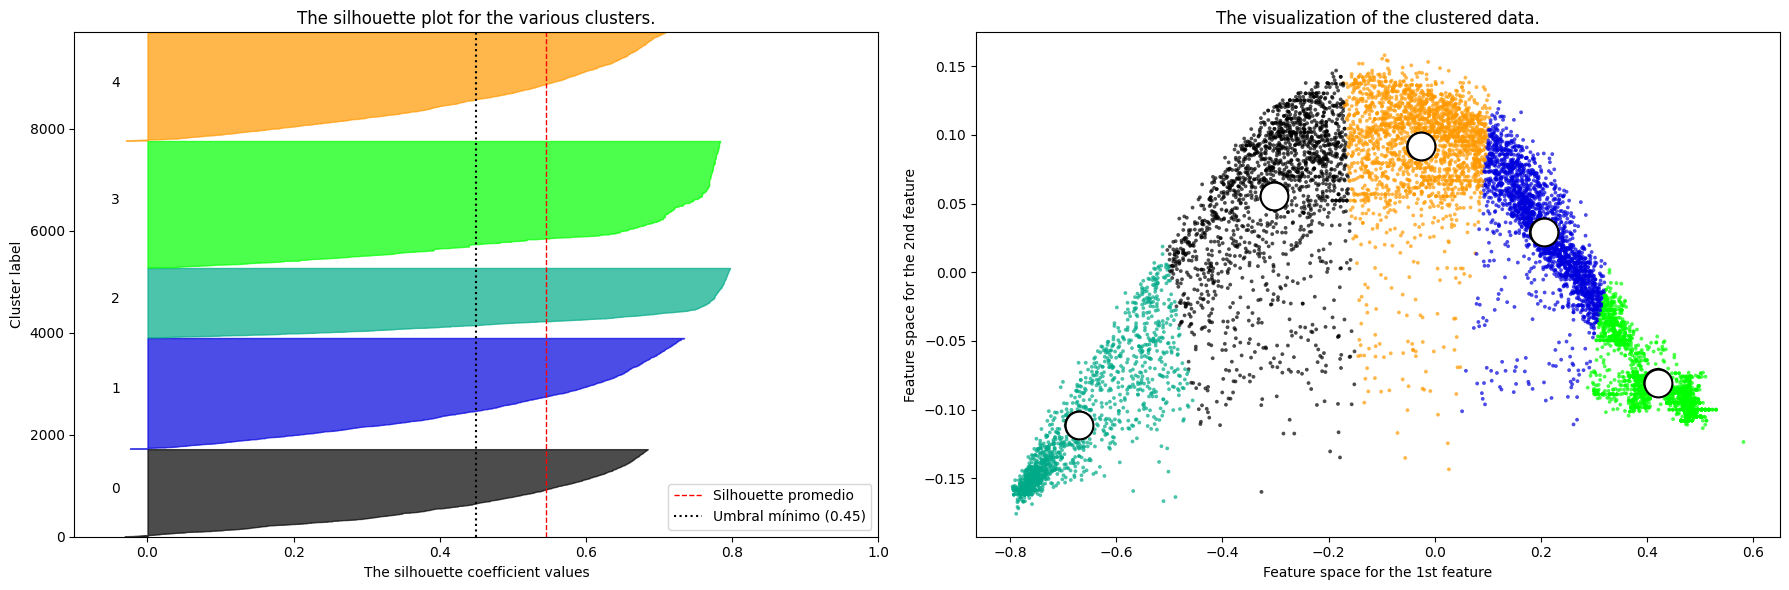

image7


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5043
Selected based on Silhouette Score (k=6)


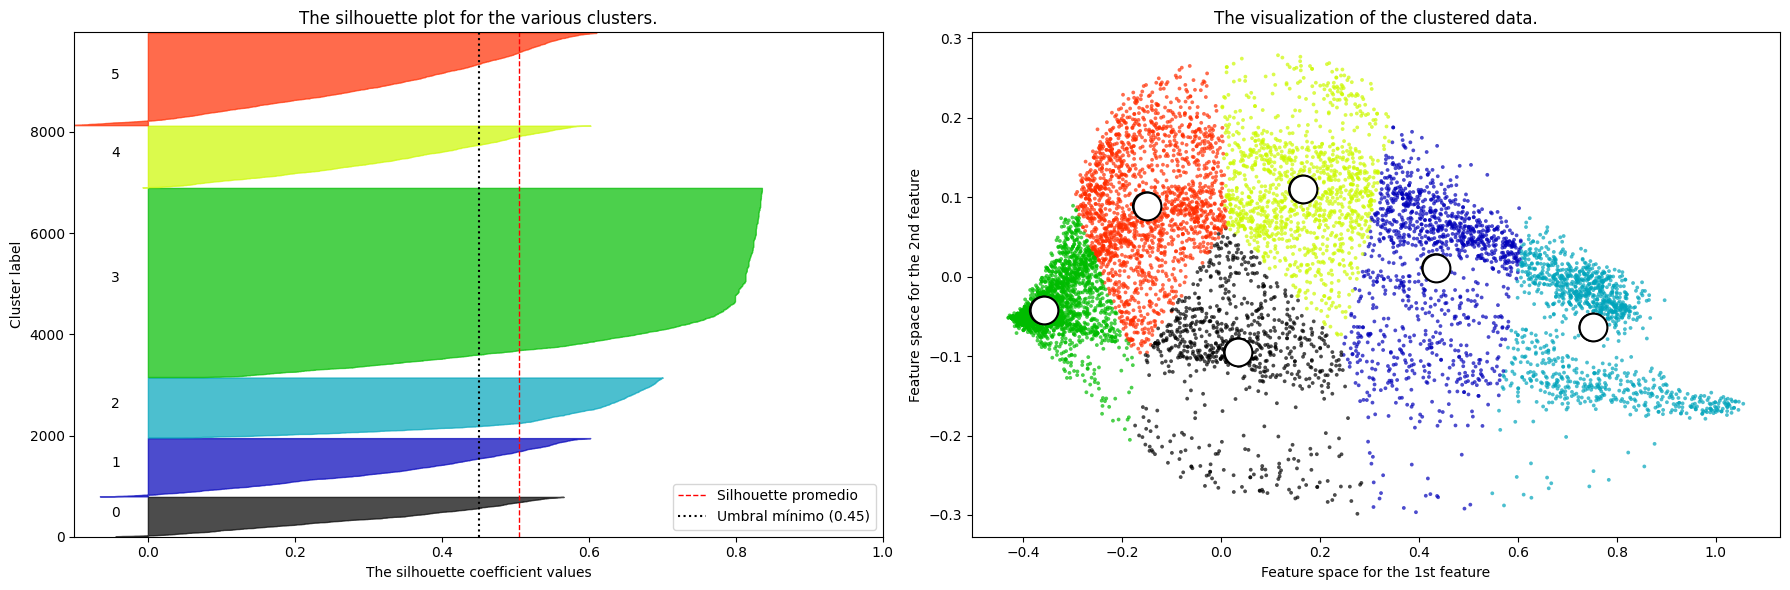

image8


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5028
Selected based on Silhouette Score (k=6)


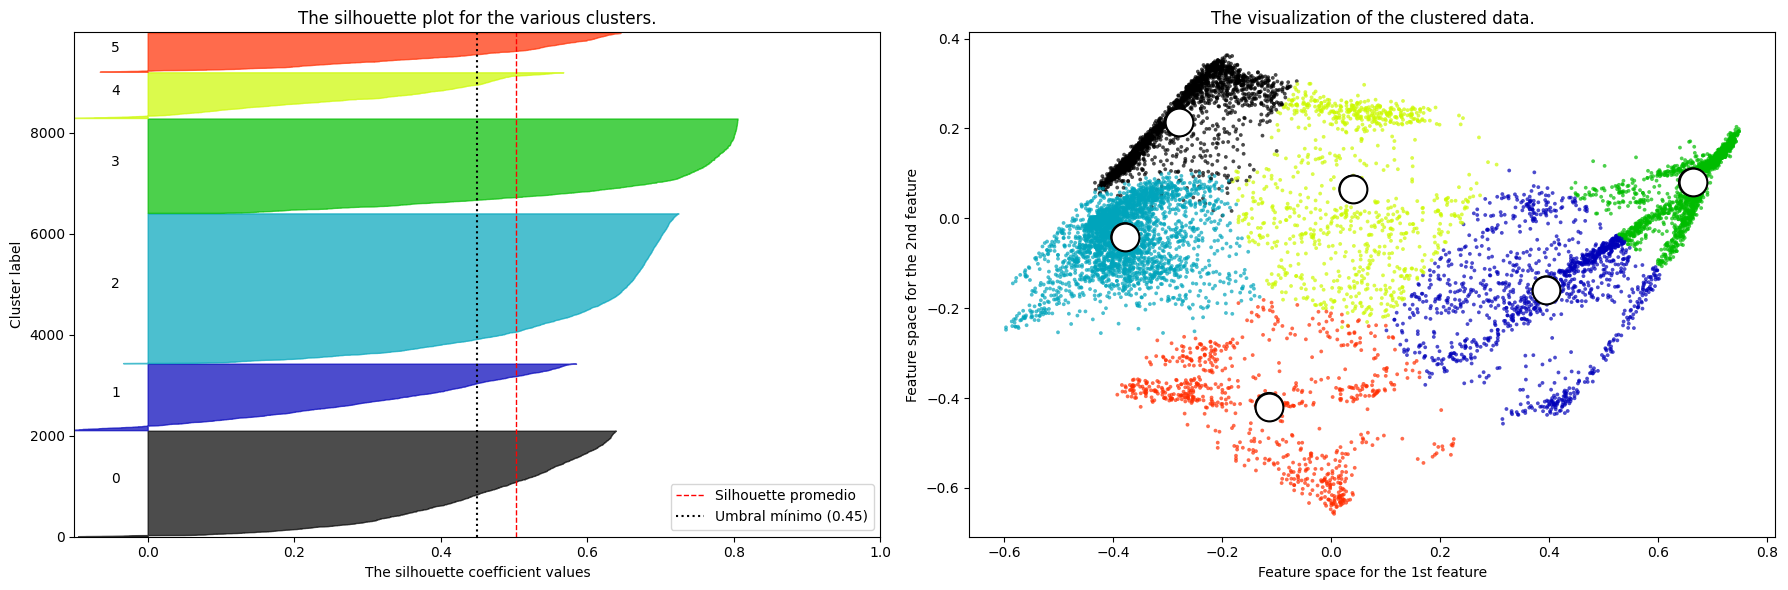

In [57]:
param_grid = {
    "n_clusters": [5, 6, 7, 8, 12]
}
min_silhoutte_score = 0.45
models_data = {}
for num_imagen, path in imgs_dict.items():
  print(num_imagen)
  image = Image()
  pipeline = create_pipeline(image)
  img_rgb = pipeline.transform(path)

  metrics_data  = find_optimal_clusters_kmeans(img_rgb,param_grid,min_silhoutte_score)
  plot_kmeans_silhouette_and_clusters(img_rgb, metrics_data,min_silhoutte_score)
  plt.show()
  models_data[num_imagen] = metrics_data

## 6. Muestrario representativo

In [66]:
def _to01(arr):
    """Lleva colores a [0,1] para mostrar en matplotlib."""
    arr = np.asarray(arr, dtype=float)
    return arr/255.0 if arr.max() > 1.0 else arr

def _infer_hw_like(original_hw, n_pixels):
    """Si el # de labels no coincide con H*W original, infiere H,W manteniendo proporción."""
    H0, W0 = original_hw
    ratio = W0 / H0
    H = int(round(np.sqrt(n_pixels / ratio)))
    W = n_pixels // H
    return H, W

def plot_palette_and_reconstruction(image_path, data_2d, metrics_data, figsize=(8,10)):
    """
    Genera una figura con:
      1) Imagen original
      2) Paleta de colores (ordenada por frecuencia)
      3) Imagen reconstruida con los centros de K-Means
    Args:
      - image_path: ruta a la imagen (para mostrar el original y sacar H,W)
      - data_2d: matriz Nx3 (RGB) usada para entrenar K-Means (tu 'img_rgb')
      - metrics_data: dict devuelto por find_optimal_clusters_kmeans(...)
    """
    # --- preparar insumos ---
    kmeans = metrics_data['best_model']
    labels = metrics_data['model_labels']
    centers = kmeans.cluster_centers_  # (k,3)

    # Imagen original
    img_orig = PILImage.open(image_path).convert('RGB')
    H0, W0 = img_orig.size[1], img_orig.size[0]  # PIL: (W,H)
    n = labels.size

    # Dimensiones para reconstrucción
    if n == H0 * W0:
        H, W = H0, W0
    else:
        H, W = _infer_hw_like((H0, W0), n)

    # Reconstrucción
    rec = centers[labels].reshape(H, W, 3)
    rec_disp = _to01(rec)

    # Paleta ordenada por frecuencia
    uniq, counts = np.unique(labels, return_counts=True)
    order = np.argsort(counts)[::-1]
    palette = _to01(centers[order])

    # Lienzo de paleta (una franja de rectángulos)
    swatch_h, swatch_w = 60, 80
    palette_img = np.zeros((swatch_h, swatch_w * len(palette), 3))
    for i, c in enumerate(palette):
        palette_img[:, i*swatch_w:(i+1)*swatch_w, :] = c

    # --- plot ---
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 1, height_ratios=[3, 0.6, 3], hspace=0.35)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img_orig)
    ax1.set_title("Imagen Original")
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.imshow(palette_img)
    ax2.set_title("Representación de la paleta")
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.imshow(rec_disp, interpolation="nearest")
    ax3.set_title("Imagen Reconstruida con los clusters")
    ax3.axis("off")


    # Subtítulo con k y criterio usado
    #k = len(centers)
    #score = metrics_data['best_score']
    #crit = metrics_data['score_type']
    #fig.suptitle(f"K={k} seleccionado por {crit} (score={score:.4f})", y=0.995, fontsize=10)

    return fig


--- image1 ---


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


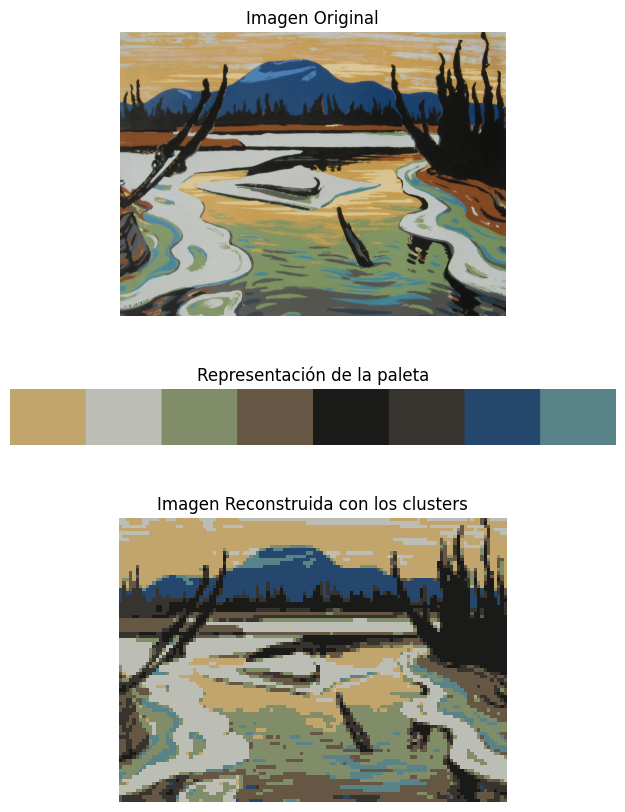

--- image2 ---


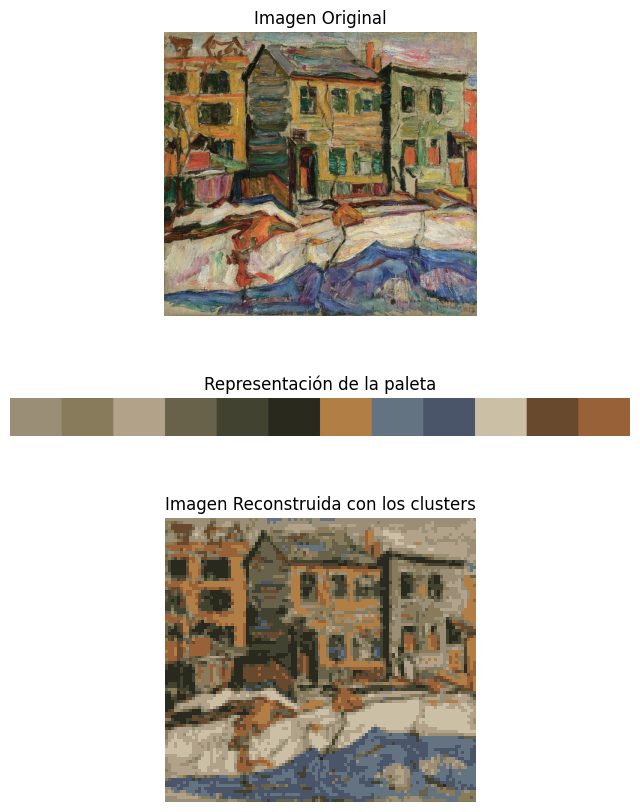

--- image3 ---


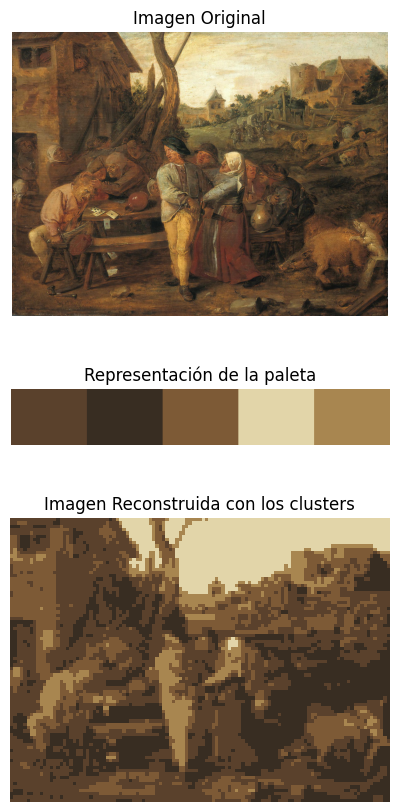

--- image4 ---


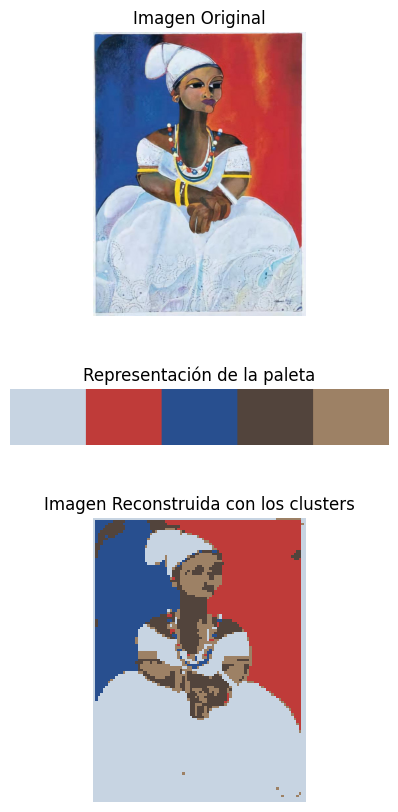

--- image5 ---


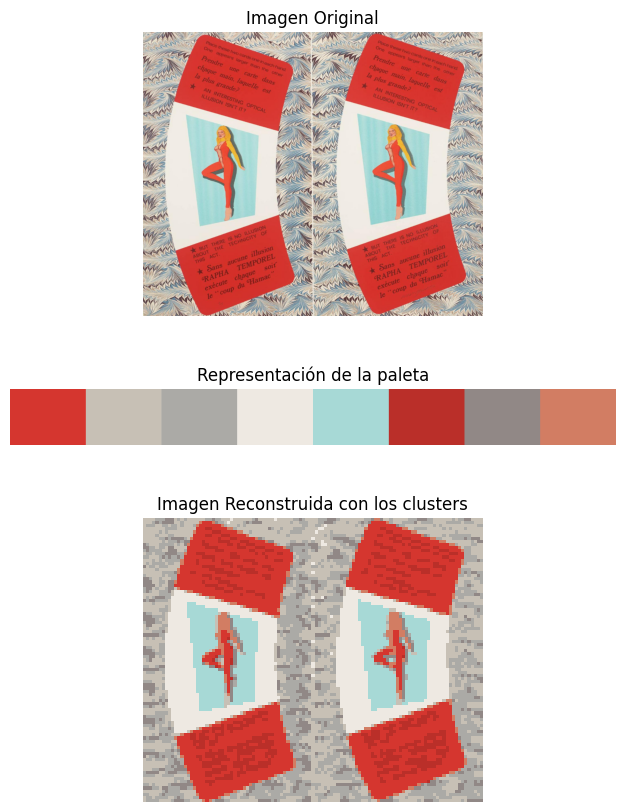

--- image6 ---


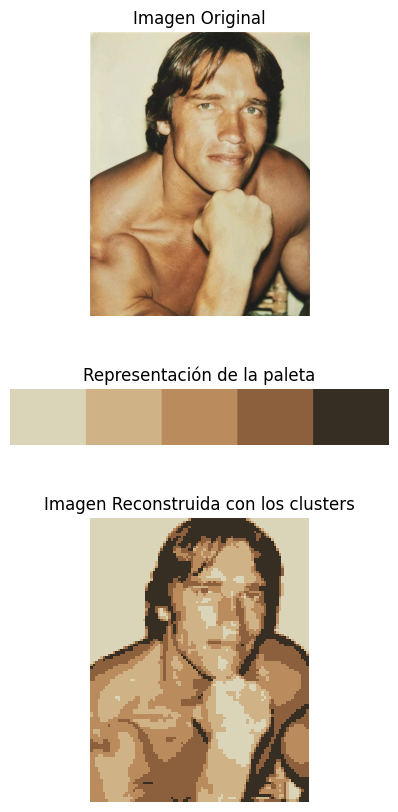

--- image7 ---


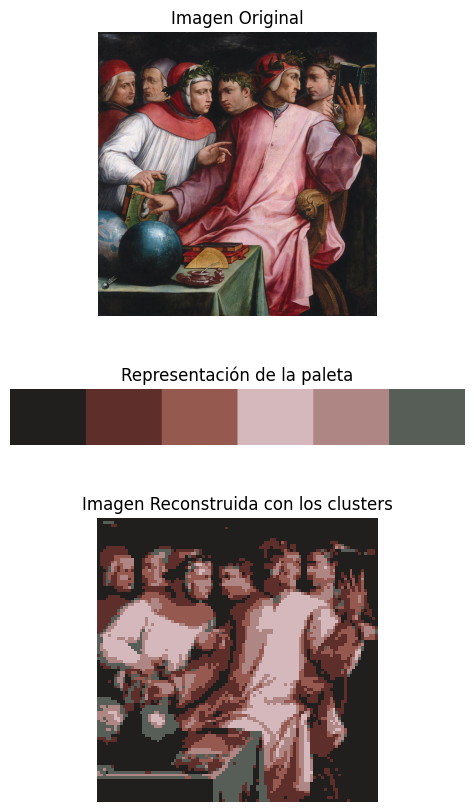

--- image8 ---


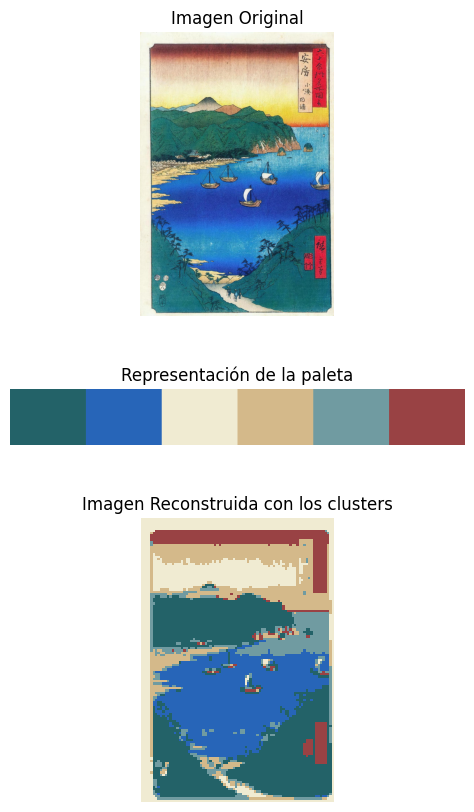

In [69]:
for num_imagen, path in imgs_dict.items():
  print(f'--- {num_imagen} ---')
  image = Image()
  pipeline = create_pipeline(image)
  img_rgb = pipeline.transform(path)  # matriz Nx3

  plot_palette_and_reconstruction(path, img_rgb, models_data[num_imagen])
  plt.show()